In [10]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy.optimize import newton
from scipy.stats import norm
from scipy import interpolate
import sys
sys.path.append('../modeling')
from SED_Funcs_custom import MagsToFluxes, InitializeExtinction

import warnings
warnings.filterwarnings('ignore')

In [12]:
## Loading in the HST/WFC3 G141 broadband light curve
bbdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/Transit_Broad_Visit3_NoFirst.npz')
times_h = bbdata['time']
rawfluxes_h = bbdata['flux']
rawerrors_h = bbdata['error']
scandirs = bbdata['scandir']

# normalizing the flux and flux error values
fluxes_h, errors_h = np.copy(rawfluxes_h), np.copy(rawerrors_h)
sd1_idxs, sd0_idxs = np.where(scandirs == 1.)[0], np.where(scandirs == 0.)[0]
normval1, normval0 = np.median(rawfluxes_h[sd1_idxs]), np.median(rawfluxes_h[sd0_idxs])
fluxes_h[sd1_idxs] /= normval1
errors_h[sd1_idxs] /= normval1
fluxes_h[sd0_idxs] /= normval0
errors_h[sd0_idxs] /= normval0

# creating the relative time arrays
t_visit_h = times_h - times_h[0]  # time since start of visit [day]

orbit_ends = np.array([17, 34, 51]) # indeces separing each orbit (note: orbit1 excluded)
orbit2times = times_h[:orbit_ends[0]]
orbit3times = times_h[orbit_ends[0] : orbit_ends[1]]
orbit4times = times_h[orbit_ends[1] : orbit_ends[2]]
# From above, compute time since beginning of orbit for each
tinorbit2 = orbit2times - orbit2times[0]
tinorbit3 = orbit3times - orbit3times[0]
tinorbit4 = orbit4times - orbit4times[0]
t_orbit_h = np.concatenate((tinorbit2, tinorbit3, tinorbit4))


## Loading in the prepped TESS data, from my 'Preparing TESS Data' notebook
tessdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/shortened_TESS_lightcurve.npz')
times_t_readin = tessdata['times']
tvoid = np.copy(times_t_readin).astype(float)
times_t = np.array(tvoid)
fluxes_t = tessdata['fluxes']
errors_t = tessdata['errs']

## Loading in the HARPS rv data (data from Esposito et al, 2019)
harpsdata = np.load('/home/mmmurphy/data/hd219666b/rv_data/HARPS_RVdata.npz')
times_rv = harpsdata['times_bjdtdb']
vels_rv = harpsdata['rvs_kms']
errs_rv = harpsdata['rverrs_kms']

#######################################################################################
# Load in SED data

# Input observed magnitudes
magfile = '../modeling/hd219666_magnitudes'

# Convert magnitudes to fluxes
bandwavs_eff, bandwidths_eff, bandfluxes, bandfluxerrs, bandnames = MagsToFluxes(magfile, Teff=5527.)

# Create dictionary of observed info
sed_obs_dict = {
    'bands': bandnames,
    'band_wavelengths':bandwavs_eff,
    'band_widths':bandwidths_eff,
    'band_fluxes':bandfluxes,
    'band_fluxerrs':bandfluxerrs
}

# Initialize interstellar extinction model
ExtinctionBase = InitializeExtinction(sed_obs_dict)

# Input model stellar spectra
specprefix = '/home/mmmurphy/data/hd219666b/stellar_models/bt-settl-cifist/lte0'
specnames = ['50','51','52','53','54','55','56','57','58','59','60']
specsuffix = '.0-4.5-0.0a+0.0.BT-Settl.spec.7.dat.txt'
modelfiles = np.asarray([(specprefix+name+specsuffix) for name in specnames])

# Teffs in [K] for which model spectra were generated
# All generated with log g = 4.5 (cgs) and metallicity = 0
modeltemps = np.asarray([5000.,5100.,5200.,5300.,5400.,5500.,5600.,5700.,5800.,5900.,6000.])

modelwavs = []
modelfluxes = []
for file in modelfiles:
    modeldata =  np.loadtxt(file, unpack=True, skiprows=8, usecols=[0,1]) 
    wavs = modeldata[0]      # wavelength [angstrom]
    flux = modeldata[1]      # flux [erg / cm2 / s / angstrom]
            
    modelwavs.append(wavs)
    modelfluxes.append(flux)
            
modelwavs = np.asarray(modelwavs)
modelfluxes = np.asarray(modelfluxes)

# Extract model fluxes only in our bands
Nmodels = modelwavs.shape[0]
Nbands = sed_obs_dict['bands'].shape[0]
band_modelfluxes = [] # List of lists; For each band, gives the flux as function of model Teff

for band in range(Nbands):
    bandwav = sed_obs_dict['band_wavelengths'][band]  # effective band wavelength [micron]
    bandwav *= 1.e4  # convert to angstron
    bandwidth = sed_obs_dict['band_widths'][band]     # effective band width [micron]
    bandwidth *= 1.e4
    
    # boundary wavelengths [angstrom] of the band
    startwav = bandwav - 0.5*bandwidth
    endwav = bandwav + 0.5*bandwidth
    
    # For this band, contains flux as function of temperature (i.e. model)
    fluxesinband = np.asarray([])
    
    for model in range(Nmodels):
    
        # wavelengths & flux/wav at this Teff
        mwavs = modelwavs[model]
        mflux = modelfluxes[model]
    
        # indices corresponding to the band
        startwav_idx = np.searchsorted(mwavs, startwav, side='left') - 1
        endwav_idx = np.searchsorted(mwavs, endwav, side='left') - 1
        
        # Pull out flux/wave for this band
        modelbandfluxes = mflux[startwav_idx:endwav_idx]  # fluxes in [erg / cm2 / s / Angstrom]
        modelbandwaves = mwavs[startwav_idx:endwav_idx]
        
        # Integrate over the band
        meanmodelbandflux = np.mean(modelbandfluxes*modelbandwaves)      
        bandintegratedflux = meanmodelbandflux            # this is now in [erg / cm2 / s]
        
        fluxesinband = np.append(fluxesinband, bandintegratedflux)
    
    band_modelfluxes.append(fluxesinband)
    
band_modelfluxes = np.asarray(band_modelfluxes)

# Generate interpolation function for each band
InterpFuncs = {}

for band in range(Nbands):
    bandname = sed_obs_dict['bands'][band]
    
    band_interpfunc = interpolate.interp1d(modeltemps, band_modelfluxes[band], kind='linear')  
    InterpFuncs[bandname] = band_interpfunc


In [15]:
labels = np.asarray(['tc', 'log10P', 'log10a', 'cosi', 'RpRs_hst', 'amp1', 'amp2', 'tau1', 'tau2', 'slope', 'intcpt', 'RpRs_tess',
                    'sqrtecosw', 'sqrtesinw', 'K', 'gamma'])
### note, when RV data confirmed to work, change transit models to pull e and w from RV params rather than using fixed vals

# Priors
c = 1. / np.log(10.)
lit_tc, lit_tc_unc = 2458329.1996, 0.0012   # [day; bjd tdb]; esposito+ 2019
lit_P, lit_P_unc = 6.034460, 0.000011       # [day]; hellier?
lit_log10P, lit_log10P_unc = np.log10(lit_P), ((c*lit_P_unc)/lit_P)
lit_rprs, lit_rprs_unc = 0.04192, 0.00083   # [Rstar]; esposito+ 2019
lit_aRs, lit_aRs_unc = 13.27, 0.39              # [Rstar]; esposito+ 2019
lit_log10aRs, lit_log10aRs_unc = np.log10(lit_aRs), ((c*lit_aRs_unc)/lit_aRs)
lit_i, lit_i_unc = 86.38, 0.15              # [degrees]; esposito+ 2019
lit_cosi, lit_cosi_unc = np.cos(lit_i*(np.pi/180.)), np.sin(lit_i*(np.pi/180.))*(lit_i_unc*(np.pi/180.))
# RV parameters
lit_K, lit_K_unc = 6.17, 0.46           # [m/s]
lit_e = 0.
lit_w = 90.*(np.pi/180.)  # [radian]
lit_par1 = np.sqrt(lit_e)*np.cos(lit_w)         
lit_par2 = np.sqrt(lit_e)*np.sin(lit_w)
lit_gamma, lit_gamma_unc = -20.0976, 0.0004   # [km/s]

theta_init = np.asarray([
    # Shared orbital parameters 
    lit_tc,                      # 0 - conjunction time
    lit_log10P,                  # 1 - log10 Period
    lit_log10aRs,                # 2 - log10 semi-major axis
    lit_cosi,                    # 3 - cosine inclination
    # Planetary parameters
    0.0431,                    # 4 - HST radius
    # HST systematic parameters
    0.00165,                       # 5 - hook amplitude for orbit 2
    0.00139,                       # 6 - hook amplitude for orbit 3 and 4
    -0.0065,                       # 7 - hook timescale for orbit 2
    -0.0057,                       # 8 - hook timescale for orbit 3 and 4
    -0.00304,                       # 9 - ramp slope
    1.0008,                       # 10 - ramp intercept
    # TESS parameter
    lit_rprs,                    # 11 - TESS radius
    # RV parameters
    lit_par1,               # 12 - sqrt(e) cos(w)
    lit_par2,               # 13 - sqrt(e) sin(w)
    lit_K,                 # 14 - RV semi-amplitude [m/s]
    lit_gamma              # 15 - system velocity [km/s]
])
priors = np.asarray([
    # Shared orbital parameters 
    lit_tc,                      # 0 - conjunction time
    lit_log10P,             # 1 - log10 Period
    lit_log10aRs,             # 2 - log10 semi-major axis
    lit_cosi,  # 3 - cosine inclination
    # Planetary parameters
    np.inf,                      # 4 - HST radius
    # HST systematic parameters
    np.inf,                      # 5 - hook amplitude
    np.inf,                      # 6
    np.inf,
    np.inf,                      # 8 - hook timescales
    np.inf,
    np.inf,                       # 10 
    lit_rprs,                     # 11 - TESS radius
    lit_par1, # 14
    lit_par2, # 15
    lit_K,    # 16
    lit_gamma  # 17
])
# set those which shouldn't have a prior to have value of infinity

c = 1. / np.log(10.)
priorserr = np.asarray([
    # Shared orbital parameters 
    lit_tc_unc,                                          # 0 - conjunction time
    lit_log10P_unc,                            # 1 - log10 Period
    lit_log10aRs_unc,                                # 2 - log10 semi-major axis
    lit_cosi_unc,  # 3 - cosine inclination
    # Planetary parameters
    lit_rprs_unc,                                         # 4 - HST radius
    # HST systematic parameters
    1.e-4,                                            # 5 - orbit 3&4 hook amplitude
    1.e-4,                                             # 6 - orbit 3&4 hook timescale
    1.e-4,                                               # 7
    1.e-4,                                             # 8
    1.e-4,                                # 9
    1.e-4,                                # 10
    lit_rprs_unc,                            # 11 - TESS radius
    1.e-3,     # 14 sqrt(e) cos(w)
    1.e-3,     # 15 sqrt(e) sin(w)
    lit_K_unc,     # 16 K [m/s]
    lit_gamma_unc     # 17 gamma [km/s]
])  # note - update these to real lit uncertainties

# Initializing the BATMAN models
InitParams = batman.TransitParams()
InitParams.t0 = theta_init[0]      
InitParams.per = 10.**theta_init[1]
InitParams.a = 10.**theta_init[2]
InitParams.inc = np.arccos(theta_init[3])*(180./np.pi)
InitParams.rp = theta_init[4]
InitParams.ecc = 0.
InitParams.w = 90.
InitParams.limb_dark = 'quadratic'
InitParams.u = [0.16, 0.31]
BATMAN_HSTinitmodel = batman.TransitModel(InitParams, times_h)
BATMAN_TESSinitmodel = batman.TransitModel(InitParams, times_t)

def transit(theta, initmodel, telescope):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    # telescope = toggle between using TESS and HST radius
    
    # Unpack input parameters
    tc = theta[0]       # time of conjunction [days]
    log10P = theta[1]   # log10( Period [days] )
    log10a = theta[2]   # log10( a / Rstar )
    cosi = theta[3]     # cosine(inclination [rad])
    if telescope == 'HST':
        rprstar = theta[4]
    elif telescope == 'TESS':
        rprstar = theta[11]
    par1 = theta[12]
    par2 = theta[13]
        
    # Transform input parameters to forms used by BATMAN
    P = 10.**(log10P)  # compute Period in [day]
    a = 10.**(log10a)  # compute a/Rstar
    inc = np.arccos(cosi)*(180./np.pi)  # Compute inclination in [deg]
    ecc = par1**2 + par2**2     # eccentricity
    omega = np.arctan2(par2, par1)  # argument of periapsis
    
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    params.limb_dark = 'quadratic'
    params.u = [0.16, 0.31]
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve
##
# Defining my systematic models
def hook(theta, torbit):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude2 = theta[5]
    amplitude3 = theta[6]
    tau2 = theta[7]
    tau3 = theta[8]
    
    hookcurve = np.zeros(len(torbit))
    hookcurve[:17] = 1. - amplitude2*np.exp(torbit[:17]/tau2)
    hookcurve[17:] = 1. - amplitude3*np.exp(torbit[17:]/tau3)
    return hookcurve

def ramp(theta, tvisit):
    # Visit-long linear model for flux in time
    # Inputs:
    # theta = array of lightcurve parameters
    # tvisit = time since start of visit in units [day]    
    slope = theta[9]
    intercept = theta[10]
    
    y = intercept + (slope*tvisit)
    return y
def timetrans_to_timeperi(tc, per, ecc, omega):
    """
    Convert Time of Transit to Time of Periastron Passage
    Args:
        tc (float): time of transit
        per (float): period [days]
        ecc (float): eccentricity
        omega (float): longitude of periastron (radians)

    Returns:
        float: time of periastron passage
        
    Copied from source code <https://radvel.readthedocs.io/en/latest/_modules/radvel/orbit.html#timetrans_to_timeperi>

    """
    try:
        if ecc >= 1:
            return tc
    except ValueError:
        pass

    f = np.pi/2 - omega
    ee = 2 * np.arctan(np.tan(f/2) * np.sqrt((1-ecc)/(1+ecc)))  # eccentric anomaly
    tp = tc - per/(2*np.pi) * (ee - ecc*np.sin(ee))      # time of periastron

    return tp

def ecc_anomaly_eqn(EA, ecc, M):
    f = EA - ecc*np.sin(EA) - M
    return f

def true_anomaly(theta, times):
    
    # Unpack parameters
    tc = theta[0]        # conjunction time [day]
    P = 10.**(theta[1])  # period [day]
    par1 = theta[12]      # sqrt(e) * cos(omega)
    par2 = theta[13]      # sqrt(e) * sin(omega)
    
    ecc = par1**2 + par2**2     # eccentricity
    w = np.arctan2(par2, par1)  # argument of periapsis
    
    # Compute time of periastron passage
    tp = timetrans_to_timeperi(tc, P, ecc, w)
    
    # Compute mean anomalies
    n =  (2. * np.pi) / P
    M = n*(times - tp)
    
    # Root-find to solve for eccentric anomaly
    EA = np.asarray([])
    for Mval in M:
        EAval = newton(ecc_anomaly_eqn, 75., args=(ecc, Mval))
        EA = np.append(EA, EAval)
    
    # Compute projections of true anomaly
    cosf = (np.cos(EA) - ecc) / (1. - ecc*np.cos(EA))
    sinf = (np.sin(EA) * np.sqrt(1. - ecc*ecc)) / (1. - ecc*np.cos(EA))
    
    # Compute true anomaly
    f = np.arctan2(sinf, cosf)
    
    return f

def radial_velocity(theta, times):
    
    # Unpack parameters
    par1 = theta[12]      # sqrt(e) * cos(omega)
    par2 = theta[13]      # sqrt(e) * sin(omega)
    K = theta[14]/1000.   # RV semi-amplitude (km/s)
    gamma = theta[15]     # RV system velocity offset (km/s)
    
    ecc = par1**2 + par2**2     # eccentricity
    w = np.arctan2(par2, par1)  # argument of periapsis
    
    
    f = true_anomaly(theta, times)
    
    arg = np.cos(w + f) + ecc*np.cos(w)
    v = K*arg + gamma
    
    return v

def stellarSED(theta, bands, InterpFuncs, ExtinctionBase):
    # Unpack parameters
    Teff = theta[0]      # Effective temperature [K]
    Rstar = theta[1]     # Stellar radius [Rsol]
    plx = theta[2]       # Parallax [milli arcsec]
    Av = theta[3]        # V-band extinction [mag]
    
    # compute distance to star in [pc]
    d_pc = 1000. / plx
    #print('Distance in parsec = ', d_pc)
    
    # Convert stellar radius to [pc]
    Rstar_pc = Rstar*2.2555823856078e-8
    
    # Compute distance & radius factor
    r2d2 = (Rstar_pc / d_pc)**2
    
    # Compute extinction attenuation factor
    tau = (ExtinctionBase)*Av
    extinction = np.exp(-tau)
    
    # Compute model energies for each band
    band_modelfluxes = np.zeros(len(bands))
    for i in range(len(bands)):
        band = bands[i]
        band_modelfluxes[i] = InterpFuncs[band](Teff)
        
    # Attenuate by radius/distance
    band_modelfluxes *= r2d2
    
    # Attenuate by extinction
    band_modelfluxes *= extinction
    
    return band_modelfluxes

def model_SED(theta, sed_dict, InterpolationFunctions, Extinction):
    # compute SED model
    model_SED = stellarSED(theta, sed_dict['bands'], InterpolationFunctions, Extinction)
    
    return model_SED

In [18]:
loadChains = True
if loadChains:
    path = '/home/mmmurphy/data/hd219666b/mcmc_results/jointfit/'
    sfile = path+'samples_50ksteps.npy'
    ffile = path+'flatsamples_50ksteps.npy'
    tfile = path+'autocorrtimes_50ksteps.npy'
    sedsfile = path+'SEDsamples_100ksteps.npy'
    sedffile = path+'SEDflatsamples_100ksteps.npy'
    sedtfile = path+'SEDautocorrtimes_100ksteps.npy'
    
    samples = np.load(sfile)
    flatsamples = np.load(ffile)
    autocorrtimes = np.load(tfile)
    
    sedsamples = np.load(sedsfile)
    sedflatsamples = np.load(sedffile)
    sedautocorrtimes = np.load(sedtfile)
    print('chains loaded in from file in ', path)
    
param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

sedparam_fits = np.asarray([np.median(sedflatsamples[:,i]) for i in range(sedsamples.shape[2])])
sedparam_uperrs = np.asarray([np.percentile(sedflatsamples[:,i], 84) for i in range(sedsamples.shape[2])]) - sedparam_fits
sedparam_loerrs = sedparam_fits - np.asarray([np.percentile(sedflatsamples[:,i], 16) for i in range(sedsamples.shape[2])])

# Generating models with best-fit parameters
bf_HSTtransit = transit(param_fits, BATMAN_HSTinitmodel, 'HST')
bf_TESStransit = transit(param_fits, BATMAN_TESSinitmodel, 'TESS')
bf_hook = hook(param_fits, t_orbit_h)
bf_ramp = ramp(param_fits, t_visit_h)
bf_HSTsys = bf_hook * bf_ramp
bf_HSTmodel = bf_HSTtransit * bf_HSTsys
bf_TESSmodel = bf_TESStransit
bf_RVmodel = radial_velocity(param_fits, times_rv)

detflux_h, deterrs_h = fluxes_h / bf_HSTsys, errors_h / bf_HSTsys


# Generating a smooth transit light curve with best-fit parameters for plotting purposes
times_h_smooth = np.linspace(times_h[0], times_h[-1], 100)
times_t_smooth = np.linspace(times_t[0], times_t[-1], 5000)
BFParams = batman.TransitParams()
BFParams.t0 = param_fits[0]      
BFParams.per = 10.**param_fits[1]
BFParams.a = 10.**param_fits[2]
BFParams.inc = np.arccos(param_fits[3])*(180./np.pi)
BFParams.rp = param_fits[4]
BFParams.ecc = 0.
BFParams.w = 90.
BFParams.limb_dark = 'quadratic'
BFParams.u = [0.33, 0.2]
BATMAN_HSTsmoothmodel = batman.TransitModel(BFParams, times_h_smooth)
transit_h_smooth = transit(param_fits, BATMAN_HSTsmoothmodel, 'HST')
BFParams.rp = param_fits[11]
BATMAN_TESSsmoothmodel = batman.TransitModel(BFParams, times_t_smooth)
transit_t_smooth = transit(param_fits, BATMAN_TESSsmoothmodel, 'TESS')

def phasefold(times, tc, per):
    phase = (times - tc)/per - np.floor((times-tc)/per)
    return phase

phase_rv = phasefold(times_rv, param_fits[0], 10.**(param_fits[1]))
RVsmoothtimes = np.linspace(min(times_rv), max(times_rv), 200, endpoint=True)
RVsmoothphase = phasefold(RVsmoothtimes, param_fits[0], 10.**(param_fits[1]))
RVsmoothmodel = radial_velocity(param_fits, RVsmoothtimes)
RVsortidxs = np.argsort(RVsmoothphase)
RVsmoothphase = RVsmoothphase[RVsortidxs]
RVsmoothmodel = RVsmoothmodel[RVsortidxs]

fitmodelSED = model_SED(sedparam_fits, sed_obs_dict, InterpFuncs, ExtinctionBase)
residuals_sed = bandfluxes - fitmodelSED
residual_std_sed = np.std(residuals_sed)
meanerror_sed = np.mean(bandfluxerrs)

chains loaded in from file in  /home/mmmurphy/data/hd219666b/mcmc_results/jointfit/


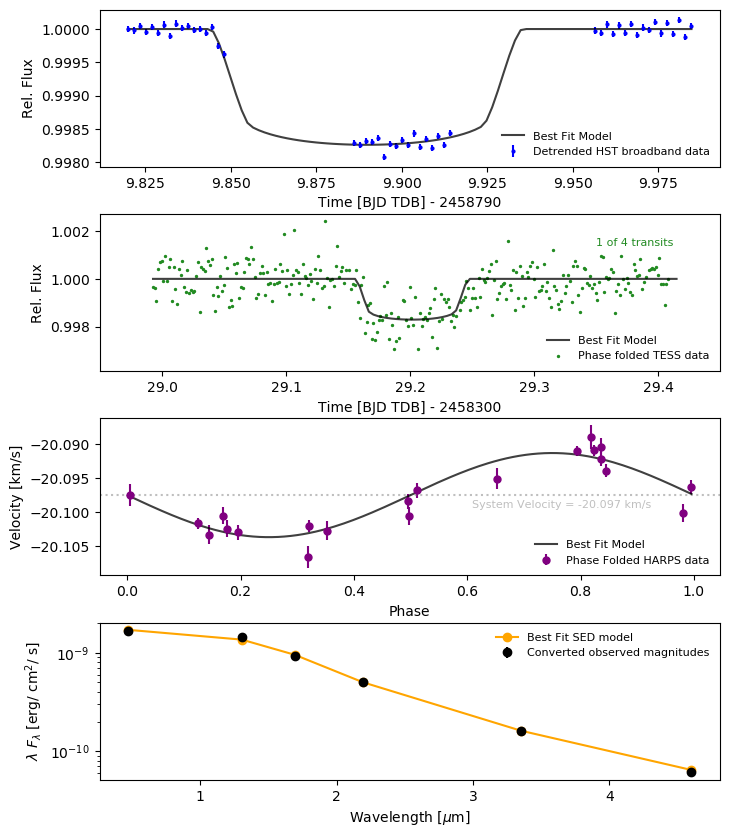

In [30]:
#lnPost_init = lnPosterior(theta_init)
#print('Initial lnPosterior:', lnPost_init)
fig, ax = plt.subplots(figsize=(8,10), nrows=4)
plt.subplots_adjust(hspace=0.3)
## Plotting the HST data
toffset_h = 2458790
ax[0].plot(times_h_smooth-toffset_h, transit_h_smooth, c='black', alpha=0.75, label='Best Fit Model')
ax[0].errorbar(times_h-toffset_h, detflux_h, deterrs_h, marker='o', ls='None', c='blue', ms=2, label='Detrended HST broadband data')
ax[0].set(xlabel='Time [BJD TDB] - %d'%(toffset_h), ylabel='Rel. Flux')
ax[0].legend(loc='lower right', frameon=False, fontsize=8)

## Plotting the TESS data
# folding the transits onto each other
# tt = times_t-2458300
# period = 10.**param_fits[1]
# tt[(tt > 32.5)] -= period
# tt[(tt > 32)] -= period
# tt[(tt > 34)] -= period
# foldedtimes_t = tt + 2458300
toffset_t = 2458300
ax[1].plot(times_t_smooth[0:115]-toffset_t, transit_t_smooth[0:115], c='black', alpha=0.75, label='Best Fit Model')
ax[1].scatter(times_t-toffset_t, fluxes_t, c='forestgreen', s=2, label='Phase folded TESS data')
ax[1].set_xlim((lit_tc-toffset_t-.25), (lit_tc-toffset_t+.25))
ax[1].set(xlabel='Time [BJD TDB] - %d'%(toffset_t), ylabel='Rel. Flux')
ax[1].text(0.8, 0.8, '1 of 4 transits', c='forestgreen', fontsize=8, transform=ax[1].transAxes)
ax[1].legend(loc='lower right', frameon=False, fontsize=8)
#ax[1].axvline(lit_tc, c='gray', alpha=0.75)


ax[2].axhline(param_fits[15], c='gray', ls='dotted', alpha=0.5)
ax[2].text(0.6, 0.43, 'System Velocity = %.3f km/s'%(param_fits[15]), c='gray', alpha=0.5, fontsize=8, transform=ax[2].transAxes)
ax[2].plot(RVsmoothphase, RVsmoothmodel, c='black', alpha=0.75, label='Best Fit Model')
ax[2].errorbar(phase_rv, vels_rv, errs_rv, ls='None', marker='o', c='purple', ms=5, label='Phase Folded HARPS data')
ax[2].set(xlabel='Phase', ylabel='Velocity [km/s]')
ax[2].legend(loc='lower right', frameon=False, fontsize=8)

ax[3].errorbar(bandwavs_eff, bandfluxes, bandfluxerrs, ls='None', c='black', marker='o', label='Converted observed magnitudes')
ax[3].plot(bandwavs_eff, fitmodelSED, color='orange', marker='o', label='Best Fit SED model')
ax[3].set_yscale('log')
ax[3].set_xlabel(r'Wavelength [$\mu$m]')
ax[3].set_ylabel(r'$\lambda~ F_\lambda$ [erg/ cm$^2$/ s]')
ax[3].legend(loc='upper right', frameon=False, fontsize=8);

plt.savefig('figures/combinedALL_jfits.png', dpi=450, bbox_inches='tight')
plt.show()